# **Instalar bibliotecas**

In [1]:
!pip install optuna
!pip install optuna-integration
!pip install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.9 MB/s eta 0:00:00


# **Importar bibliotecas**

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import glob
import warnings
import math
import optuna
import keras
import logging
import sys
import gc

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import linregress
from keras.models import model_from_json
from keras.models import Sequential, Model
from keras.layers import LSTM, Dropout, Bidirectional, Dense, Input
from keras import backend as K
from tensorflow.keras import regularizers
from google.colab import drive
from google.colab import files
from google.colab import data_table
from google.colab import output
output.enable_custom_widget_manager()
from optuna.integration import KerasPruningCallback
from optuna.trial import TrialState
# from numba import cuda

warnings.filterwarnings("ignore")
drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/Doutorado/Testes_corretos')
data_table.enable_dataframe_formatter()

Mounted at /content/drive/


# **Váriaveis iniciais**

In [4]:
global look_back
look_back = 2             # number of time steps used to predict
ni=7                       # number of input variables
no=1                       # number of output variables
test_split_size = 0.2
filter_size = 60           # "moving-average" in seconds

# **Função de normalização: (-1, 1)**

In [15]:
def normalizacao(x, maximos, minimos):
  dados_norm = 1-2*((maximos-x)/(maximos-minimos))
  return dados_norm

# **Função de denormalização: (-1, 1)**

In [6]:
def denormalizacao(x, maximos, minimos):
  dados_denorm = maximos-((1-x)*(maximos-minimos))/2
  return dados_denorm

# **Funções para salvar e carregar o modelo neural**

In [7]:
# serialize model to JSON
def save_LSTM_model(model):
  path_save = '/content/drive/MyDrive/Doutorado/Códigos/Bayesian/Models/look_back_{look_back}_no_{no}'.format(look_back = str(look_back), no = str(no))
  if not os.path.exists(path_save):
    os.mkdir(path_save)
  os.chdir(path_save)
  model_json = model.to_json()
  with open("model.json", "w") as json_file:
      json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights("model.h5")
  !cp model.h5 path_save
  !cp model.json path_save
  os.chdir('/content/drive/MyDrive/Doutorado/Testes_corretos')
  print("Saved model to disk")
  return
  # # Load RNN

def load_LSTM_model():
  json_file = open('/content/drive/MyDrive/Doutorado/Códigos/Bayesian/model.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  model = model_from_json(loaded_model_json)
  # load weights into new model
  model.load_weights("/content/drive/MyDrive/Doutorado/Códigos/Bayesian/model.h5")
  print("Loaded model from disk")
  return model

# **Cálculo da variável delta de saída**

In [8]:
def deltay(dados, bstep): # dados must be a np array
  max_index = len(dados)
  Dy = dados[bstep:max_index+1]-dados[bstep-1:max_index-1]
  return Dy

# **Organizar o vetor de saída com k predições**

In [9]:
def ytest(Dy, fstep): # Dt must be a np array
  max_index = len(Dy)
  aux_array = np.empty([max_index-fstep, fstep])
  i = 0
  for i in range(max_index-fstep):
    aux_array[i, :] = Dy[i:i+fstep]
    i += 1
  return aux_array

# **Gerar estrutura do banco de dados para treinamento**

In [10]:
# Creating a data structure with look_back timesteps and k outputs
def create_dataset(training_set_scaled, look_back):
    x_train, y_train = [], []
    for i in range(look_back, len(training_set_scaled)):
        x_train.append(training_set_scaled[i - look_back:i, 0:ni])
        y_train.append(training_set_scaled[i, ni:ni+no])
    return np.array(x_train).astype('float32'), np.array(y_train).astype('float32')

# **Cálculo da predição e incerteza**

In [11]:
def predict_with_uncertainty(model, x, n_iter):
    result = np.zeros((n_iter,) + (x.shape[0], no))
    for i in range(n_iter):
        result[i,:, :] = model(x)
    prediction = result.mean(axis=0)
    uncertainty = result.std(axis=0)
    return prediction, uncertainty


# **Importar dados**

In [12]:
def criar_dataset():
  path = os.getcwd()
  csv_files = glob.glob(os.path.join(path, "*.xlsx"))
  dataset = []
  first_loop = 0
  for file_name in csv_files:
      df = pd.read_excel(file_name, na_filter = False)
      i = 0
      mean_values = []
      while i <= df.shape[0]:
        a = df[i:i+filter_size].mean()
        a.values.tolist()
        mean_values.append(a)
        i += filter_size
      m = pd.DataFrame(mean_values)
      outlet_turb = np.array(m['Outlet turbidity'])
      input_var = m[['Inlet Turbidity (NTU)', 'Inflow (L/min)', 'Recicle flow (L/min)', 'Pressure (bar)', 'Temperature (ºC)', 'Level (cm)', 'Outlet turbidity']]
      Dy_vector = deltay(outlet_turb, look_back)
      # kDy_matrix = ytest(Dy_vector, no)
      kDy_matrix = ytest(outlet_turb[look_back:len(outlet_turb)+1], no)
      dados_real = np.array(input_var)
      data = np.hstack([dados_real[0:len(dados_real)-look_back-no, :], kDy_matrix])
      x_d, y_d = create_dataset(data, look_back)
      if first_loop == 0:
        x_f = x_d
        y_f = y_d
        first_loop = 1
      else:
        x_f = np.append(x_f, x_d, axis=0)
        y_f = np.append(y_f, y_d, axis=0)
  return x_f, y_f

# **Normalização e criação dos dados para treinamento**

In [13]:
def norm_dataset(x_f, y_f):
  x_maximos = x_f.max(axis=0)
  x_minimos = x_f.min(axis=0)
  x_norm = normalizacao(x_f, x_maximos, x_minimos)
  x_train, x_test = train_test_split(x_norm, test_size=test_split_size, shuffle=False)

  y_maximos = y_f.max(axis=0)
  y_minimos = y_f.min(axis=0)
  y_norm = normalizacao(y_f, y_maximos, y_minimos)
  y_train, y_test = train_test_split(y_norm, test_size=test_split_size, shuffle=False)

  return x_train, x_test, y_train, y_test, x_maximos, x_minimos, y_maximos, y_minimos

# **Criar banco de dados**

In [14]:
x_f, y_f = criar_dataset()
global x_train, x_test, y_train, y_test
x_train, x_test, y_train, y_test, x_maximos, x_minimos, y_maximos, y_minimos = norm_dataset(x_f, y_f)

TypeError: Could not convert ['2023-07-08-11h04min41s2023-07-08-11h04min42s2023-07-08-11h04min43s2023-07-08-11h04min44s2023-07-08-11h04min45s2023-07-08-11h04min46s2023-07-08-11h04min47s2023-07-08-11h04min48s2023-07-08-11h04min49s2023-07-08-11h04min50s2023-07-08-11h04min51s2023-07-08-11h04min52s2023-07-08-11h04min53s2023-07-08-11h04min54s2023-07-08-11h04min55s2023-07-08-11h04min56s2023-07-08-11h04min57s2023-07-08-11h04min58s2023-07-08-11h04min59s2023-07-08-11h05min00s2023-07-08-11h05min01s2023-07-08-11h05min02s2023-07-08-11h05min03s2023-07-08-11h05min04s2023-07-08-11h05min05s2023-07-08-11h05min06s2023-07-08-11h05min07s2023-07-08-11h05min08s2023-07-08-11h05min09s2023-07-08-11h05min10s2023-07-08-11h05min11s2023-07-08-11h05min12s2023-07-08-11h05min13s2023-07-08-11h05min14s2023-07-08-11h05min15s2023-07-08-11h05min16s2023-07-08-11h05min17s2023-07-08-11h05min18s2023-07-08-11h05min19s2023-07-08-11h05min20s2023-07-08-11h05min21s2023-07-08-11h05min22s2023-07-08-11h05min23s2023-07-08-11h05min24s2023-07-08-11h05min25s2023-07-08-11h05min26s2023-07-08-11h05min27s2023-07-08-11h05min28s2023-07-08-11h05min29s2023-07-08-11h05min30s2023-07-08-11h05min31s2023-07-08-11h05min32s2023-07-08-11h05min33s2023-07-08-11h05min34s2023-07-08-11h05min35s2023-07-08-11h05min36s2023-07-08-11h05min37s2023-07-08-11h05min38s2023-07-08-11h05min39s2023-07-08-11h05min40s'] to numeric

# **Criar modelo para o optuna**

In [ ]:
def create_model(trial):

  neurons = trial.suggest_int('neurons', ni, 100*ni)
  L1 = trial.suggest_float("L1", 1e-5, 1e-1, log=True)
  L2 = trial.suggest_float("L2", 1e-5, 1e-1, log=True)
  do = trial.suggest_float("do", 0.1, 0.5)
  lr_sug = trial.suggest_float('init_lr', 0.0000001, 0.01)
  K.clear_session()
  # tf.keras.backend.clear_session()
# Definição do modelo neural
  inp = Input(shape=(look_back, ni))
  x = LSTM(neurons, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2))(inp)
  x = Dropout(rate=do)(x, training=True)
  out = Dense(no)(x)
  model = Model(inp, out)

  opt = keras.optimizers.Adam(learning_rate=lr_sug)

  model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mse'])
  return model

# **Função objetivo - Optuna**

In [ ]:
def objective(trial):
  # Clear clutter from previous session graphs.
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
  model = create_model(trial)
  model.fit(x_train, y_train, batch_size=64, callbacks=[KerasPruningCallback(trial, "val_loss"), es],
        epochs=50, validation_data=(x_test, y_test), verbose=0)
  score = model.evaluate(x_test, y_test, verbose=1)
  print(gc.collect())
  return score[1]

# **Inicializar a busca dos hiperparâmetros**

In [ ]:
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.SuccessiveHalvingPruner())
# study.optimize(objective, n_trials=250)
study.optimize(objective, n_trials=250, gc_after_trial=True, callbacks=[lambda study, trial: gc.collect()])
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-11-17 15:09:05,742] A new study created in memory with name: no-name-eedeb9ed-c6b1-4d63-934b-68979c1cdf28


11/11 [==============================] - 0s 23ms/step - loss: 0.0509 - mse: 0.0444


[I 2023-11-17 15:10:31,129] Trial 0 finished with value: 0.0443962924182415 and parameters: {'neurons': 538, 'L1': 0.0006523750754537049, 'L2': 1.5566756959298004e-05, 'do': 0.38581788463224453, 'init_lr': 0.0026883790090717966}. Best is trial 0 with value: 0.0443962924182415.


2049
11/11 [==============================] - 0s 8ms/step - loss: 0.1085 - mse: 0.0647


[I 2023-11-17 15:10:53,052] Trial 1 finished with value: 0.06467985361814499 and parameters: {'neurons': 225, 'L1': 0.007347668900452092, 'L2': 0.00021708310766510027, 'do': 0.1911758923688901, 'init_lr': 0.007540727123464945}. Best is trial 0 with value: 0.0443962924182415.


2112
11/11 [==============================] - 0s 12ms/step - loss: 0.0780 - mse: 0.0422


[I 2023-11-17 15:11:17,410] Trial 2 finished with value: 0.04224909842014313 and parameters: {'neurons': 241, 'L1': 0.009101627082747836, 'L2': 1.034228154345921e-05, 'do': 0.36737352987048455, 'init_lr': 0.004525589120813293}. Best is trial 2 with value: 0.04224909842014313.


2120
11/11 [==============================] - 0s 6ms/step - loss: 0.0616 - mse: 0.0500


[I 2023-11-17 15:11:28,441] Trial 3 finished with value: 0.050030291080474854 and parameters: {'neurons': 84, 'L1': 0.0035553925836788202, 'L2': 0.00502867298105012, 'do': 0.2621187337671933, 'init_lr': 0.008670516888205793}. Best is trial 2 with value: 0.04224909842014313.


2119
11/11 [==============================] - 0s 3ms/step - loss: 0.0873 - mse: 0.0852


[I 2023-11-17 15:11:37,894] Trial 4 finished with value: 0.08523475378751755 and parameters: {'neurons': 26, 'L1': 3.321781248370404e-05, 'L2': 0.00020109431824628108, 'do': 0.15316668988103516, 'init_lr': 0.006254730572780808}. Best is trial 2 with value: 0.04224909842014313.


2116


[I 2023-11-17 15:11:42,987] Trial 5 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 15:11:51,010] Trial 6 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 15:12:00,237] Trial 7 pruned. Trial was pruned at epoch 1.


11/11 [==============================] - 0s 17ms/step - loss: 0.0470 - mse: 0.0405


[I 2023-11-17 15:13:10,165] Trial 8 finished with value: 0.040509313344955444 and parameters: {'neurons': 456, 'L1': 0.0007491057811247341, 'L2': 0.052144220019091636, 'do': 0.16830128897604557, 'init_lr': 0.0028967934584157185}. Best is trial 8 with value: 0.040509313344955444.


2121


[I 2023-11-17 15:13:22,847] Trial 9 pruned. Trial was pruned at epoch 16.
[I 2023-11-17 15:13:39,198] Trial 10 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 15:13:46,401] Trial 11 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 15:13:55,319] Trial 12 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 15:14:06,659] Trial 13 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 15:14:16,219] Trial 14 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 15:14:27,887] Trial 15 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 15:14:37,105] Trial 16 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 15:14:51,743] Trial 17 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 15:14:58,829] Trial 18 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 15:15:06,527] Trial 19 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 15:15:15,880] Trial 20 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 15:15:26,477] Trial 21 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 15:15:39,972] Trial 22 p

11/11 [==============================] - 0s 36ms/step - loss: 0.0522 - mse: 0.0467


[I 2023-11-17 15:30:19,728] Trial 81 finished with value: 0.046683602035045624 and parameters: {'neurons': 435, 'L1': 0.0006120449645487725, 'L2': 0.02737175721871587, 'do': 0.1814257670483445, 'init_lr': 0.002947046079499987}. Best is trial 8 with value: 0.040509313344955444.


2117


[I 2023-11-17 15:31:12,128] Trial 82 pruned. Trial was pruned at epoch 16.
[I 2023-11-17 15:32:21,594] Trial 83 pruned. Trial was pruned at epoch 16.
[I 2023-11-17 15:33:25,882] Trial 84 pruned. Trial was pruned at epoch 16.


11/11 [==============================] - 0s 19ms/step - loss: 0.0449 - mse: 0.0406


[I 2023-11-17 15:34:56,775] Trial 85 finished with value: 0.0406445749104023 and parameters: {'neurons': 425, 'L1': 0.0002729408663123604, 'L2': 0.03438067769802131, 'do': 0.1634900749336493, 'init_lr': 0.0029517324395162783}. Best is trial 8 with value: 0.040509313344955444.


2113


[I 2023-11-17 15:35:13,477] Trial 86 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 15:35:41,366] Trial 87 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 15:36:02,197] Trial 88 pruned. Trial was pruned at epoch 4.


11/11 [==============================] - 0s 11ms/step - loss: 0.0524 - mse: 0.0475


[I 2023-11-17 15:36:50,880] Trial 89 finished with value: 0.04748423397541046 and parameters: {'neurons': 292, 'L1': 0.00036612429840990384, 'L2': 0.03621990980643851, 'do': 0.20673693124392062, 'init_lr': 0.0028393209459657504}. Best is trial 8 with value: 0.040509313344955444.


2110


[I 2023-11-17 15:37:03,462] Trial 90 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 15:37:11,650] Trial 91 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 15:37:27,084] Trial 92 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 15:37:44,773] Trial 93 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 15:38:02,778] Trial 94 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 15:38:15,707] Trial 95 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 15:38:33,565] Trial 96 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 15:38:45,503] Trial 97 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 15:38:56,282] Trial 98 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 15:39:10,633] Trial 99 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 15:39:32,469] Trial 100 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 15:39:41,148] Trial 101 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 15:39:53,043] Trial 102 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 15:40:01,946] Trial 1

11/11 [==============================] - 0s 18ms/step - loss: 0.0379 - mse: 0.0337


[I 2023-11-17 15:51:40,482] Trial 138 finished with value: 0.03373125195503235 and parameters: {'neurons': 342, 'L1': 0.0003256815710204294, 'L2': 0.028538213680657048, 'do': 0.1971018711716299, 'init_lr': 0.0027931555069354973}. Best is trial 138 with value: 0.03373125195503235.


2107


[I 2023-11-17 15:51:59,094] Trial 139 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 15:52:14,385] Trial 140 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 15:52:37,455] Trial 141 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 15:52:51,840] Trial 142 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 15:53:17,464] Trial 143 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 15:53:31,368] Trial 144 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 15:53:44,853] Trial 145 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 15:53:56,556] Trial 146 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 15:54:12,413] Trial 147 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 15:54:29,539] Trial 148 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 15:54:42,337] Trial 149 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 15:54:57,776] Trial 150 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 15:55:10,716] Trial 151 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 15:55:23,02

11/11 [==============================] - 0s 4ms/step - loss: 0.0606 - mse: 0.0559


[I 2023-11-17 16:10:59,890] Trial 196 finished with value: 0.05594632402062416 and parameters: {'neurons': 100, 'L1': 0.0002436619879813243, 'L2': 3.098320662310342e-05, 'do': 0.41366940876221586, 'init_lr': 0.007615009328941298}. Best is trial 138 with value: 0.03373125195503235.


2120


[I 2023-11-17 16:11:10,550] Trial 197 pruned. Trial was pruned at epoch 4.


11/11 [==============================] - 0s 5ms/step - loss: 0.0604 - mse: 0.0560


[I 2023-11-17 16:11:32,706] Trial 198 finished with value: 0.05597082898020744 and parameters: {'neurons': 106, 'L1': 0.00014198893588060065, 'L2': 0.008601631386019225, 'do': 0.40894060761761863, 'init_lr': 0.007860704084133682}. Best is trial 138 with value: 0.03373125195503235.


2120


[I 2023-11-17 16:11:48,306] Trial 199 pruned. Trial was pruned at epoch 16.
[I 2023-11-17 16:12:04,297] Trial 200 pruned. Trial was pruned at epoch 16.


11/11 [==============================] - 0s 8ms/step - loss: 0.0543 - mse: 0.0514


[I 2023-11-17 16:12:28,526] Trial 201 finished with value: 0.05140244960784912 and parameters: {'neurons': 114, 'L1': 9.884898339237404e-05, 'L2': 4.341058465614547e-05, 'do': 0.40267417743868344, 'init_lr': 0.007865927420628745}. Best is trial 138 with value: 0.03373125195503235.


2107


[I 2023-11-17 16:12:38,912] Trial 202 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 16:13:01,671] Trial 203 pruned. Trial was pruned at epoch 16.


11/11 [==============================] - 0s 9ms/step - loss: 0.0609 - mse: 0.0571


[I 2023-11-17 16:13:32,791] Trial 204 finished with value: 0.05705913156270981 and parameters: {'neurons': 115, 'L1': 0.00018146900706621216, 'L2': 4.3832437412800645e-05, 'do': 0.40768608773632176, 'init_lr': 0.007987884290693446}. Best is trial 138 with value: 0.03373125195503235.


2107
11/11 [==============================] - 0s 6ms/step - loss: 0.0658 - mse: 0.0616


[I 2023-11-17 16:13:53,714] Trial 205 finished with value: 0.061579421162605286 and parameters: {'neurons': 130, 'L1': 0.0001959380299587068, 'L2': 5.6491433349472766e-05, 'do': 0.402832205911549, 'init_lr': 0.007991168872126975}. Best is trial 138 with value: 0.03373125195503235.


2120


[I 2023-11-17 16:14:15,078] Trial 206 pruned. Trial was pruned at epoch 16.
[I 2023-11-17 16:14:32,248] Trial 207 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 16:14:44,121] Trial 208 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 16:14:59,883] Trial 209 pruned. Trial was pruned at epoch 16.
[I 2023-11-17 16:15:13,865] Trial 210 pruned. Trial was pruned at epoch 4.


11/11 [==============================] - 0s 9ms/step - loss: 0.0355 - mse: 0.0289


[I 2023-11-17 16:15:39,793] Trial 211 finished with value: 0.02894756942987442 and parameters: {'neurons': 159, 'L1': 0.00014656711372419885, 'L2': 0.007397516657099, 'do': 0.4028349271302991, 'init_lr': 0.0073220193945774835}. Best is trial 211 with value: 0.02894756942987442.


2121


[I 2023-11-17 16:15:52,097] Trial 212 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 16:16:13,218] Trial 213 pruned. Trial was pruned at epoch 16.
[I 2023-11-17 16:16:27,015] Trial 214 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 16:16:47,217] Trial 215 pruned. Trial was pruned at epoch 16.
[I 2023-11-17 16:17:02,487] Trial 216 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 16:17:19,137] Trial 217 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 16:17:32,819] Trial 218 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 16:17:48,147] Trial 219 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 16:18:04,606] Trial 220 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 16:18:23,435] Trial 221 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 16:18:37,303] Trial 222 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 16:18:53,110] Trial 223 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 16:19:12,446] Trial 224 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 16:19:26,

11/11 [==============================] - 0s 10ms/step - loss: 0.0692 - mse: 0.0653


[I 2023-11-17 16:20:46,022] Trial 229 finished with value: 0.0652562603354454 and parameters: {'neurons': 182, 'L1': 8.325115748342873e-05, 'L2': 0.0024894518874909763, 'do': 0.4193346178486184, 'init_lr': 0.008171206652469681}. Best is trial 211 with value: 0.02894756942987442.


2117


[I 2023-11-17 16:20:57,841] Trial 230 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 16:21:10,049] Trial 231 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 16:21:28,467] Trial 232 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 16:21:42,451] Trial 233 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 16:21:59,275] Trial 234 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 16:22:13,863] Trial 235 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 16:22:29,826] Trial 236 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 16:22:48,082] Trial 237 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 16:23:03,941] Trial 238 pruned. Trial was pruned at epoch 4.
[I 2023-11-17 16:23:16,596] Trial 239 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 16:23:41,001] Trial 240 pruned. Trial was pruned at epoch 16.
[I 2023-11-17 16:24:02,528] Trial 241 pruned. Trial was pruned at epoch 4.


11/11 [==============================] - 0s 4ms/step - loss: 0.0363 - mse: 0.0315


[I 2023-11-17 16:24:25,641] Trial 242 finished with value: 0.031474992632865906 and parameters: {'neurons': 96, 'L1': 0.00022541006975457836, 'L2': 0.0057274903845254835, 'do': 0.4194581986984199, 'init_lr': 0.007667351366701924}. Best is trial 211 with value: 0.02894756942987442.


2121


[I 2023-11-17 16:24:49,978] Trial 243 pruned. Trial was pruned at epoch 16.
[I 2023-11-17 16:25:01,250] Trial 244 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 16:25:13,679] Trial 245 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 16:25:33,741] Trial 246 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 16:25:50,181] Trial 247 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 16:26:05,176] Trial 248 pruned. Trial was pruned at epoch 1.
[I 2023-11-17 16:26:17,508] Trial 249 pruned. Trial was pruned at epoch 1.


Study statistics: 
  Number of finished trials:  250
  Number of pruned trials:  232
  Number of complete trials:  18
Best trial:
  Value:  0.02894756942987442
  Params: 
    neurons: 159
    L1: 0.00014656711372419885
    L2: 0.007397516657099
    do: 0.4028349271302991
    init_lr: 0.0073220193945774835


# **Salvar melhor conjunto de hiperparâmetros**

In [ ]:
best_params = study.best_params
neurons = best_params['neurons']
L1 = best_params['L1']
L2 = best_params['L2']
do = best_params['do']
init_lr = best_params['init_lr']

# **Exibir desempenho dos 10 melhores modelos**

In [ ]:
N_PLOTTED_TRIALS = 10
trials = study.trials
plotted_trials = sorted(trials, key=lambda t: t.value)[:N_PLOTTED_TRIALS]
plotted_study = optuna.create_study()
for trial in plotted_trials:
    plotted_study.add_trial(trial)
opt_history = optuna.visualization.plot_optimization_history(plotted_study)
optuna.visualization.plot_optimization_history(study)

[I 2023-11-17 16:26:30,705] A new study created in memory with name: no-name-c12d28ef-6621-45c3-9892-12e8a51b1823


In [ ]:
optuna.visualization.plot_intermediate_values(plotted_study)

In [ ]:
optuna.visualization.plot_contour(study)

In [ ]:
# Get parameters sorted by the importance values
importances = optuna.importance.get_param_importances(study)
params_sorted = list(importances.keys())

# Plot
optuna.visualization.plot_rank(study)
# optuna.visualization.plot_rank(study, params=[params_sorted[0], params_sorted[1]])

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
df = study.trials_dataframe(attrs=("number", "value", "params", "state"))
df.to_excel('/content/drive/MyDrive/Doutorado/Códigos/Bayesian/data_look_back_{look_back}_no_{no}.xlsx'.format(look_back = str(look_back), no = str(no)))

## **Salvar/Carregar modelo**

In [ ]:
# save_LSTM_model(model)
# model = load_LSTM_model()

In [ ]:
def final_model(neurons, L1, L2, do, lr_sug):

# Definição do modelo neural
  inp = Input(shape=(look_back, ni))
  x = LSTM(neurons, kernel_regularizer=regularizers.L1L2(l1=L1, l2=L2))(inp)
  x = Dropout(rate=do)(x, training=True)
  out = Dense(no)(x)
  model = Model(inp, out)
  opt = keras.optimizers.Adam(learning_rate=lr_sug)
  model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mse'])
  keras.backend.clear_session()
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
  mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss',
                       mode='auto', verbose=0, save_best_only=True)
  model = create_model(trial)
  model.fit(x_train, y_train, batch_size=64, callbacks=[es, mc], epochs=50,
        validation_data=(x_test, y_test), verbose=1)
  return model

In [ ]:
model = final_model(neurons, L1, L2, do, init_lr)
save_LSTM_model(model)
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)
testScore = mean_squared_error(y_test, test_predict)
testScore

Epoch 1/50
22/22 [==============================] - 6s 182ms/step - loss: 0.2801 - mse: 0.0467 - val_loss: 0.0979 - val_mse: 0.0350
Epoch 2/50
22/22 [==============================] - 3s 151ms/step - loss: 0.0617 - mse: 0.0215 - val_loss: 0.0592 - val_mse: 0.0409
Epoch 3/50
22/22 [==============================] - 2s 109ms/step - loss: 0.0349 - mse: 0.0223 - val_loss: 0.0399 - val_mse: 0.0319
Epoch 4/50
22/22 [==============================] - 2s 87ms/step - loss: 0.0301 - mse: 0.0231 - val_loss: 0.0612 - val_mse: 0.0542
Epoch 5/50
22/22 [==============================] - 2s 88ms/step - loss: 0.0317 - mse: 0.0249 - val_loss: 0.0424 - val_mse: 0.0355
Epoch 6/50
22/22 [==============================] - 2s 88ms/step - loss: 0.0275 - mse: 0.0208 - val_loss: 0.0378 - val_mse: 0.0319
Epoch 7/50
22/22 [==============================] - 2s 95ms/step - loss: 0.0263 - mse: 0.0206 - val_loss: 0.0418 - val_mse: 0.0362
Epoch 8/50
22/22 [==============================] - 2s 112ms/step - loss: 0.0278

0.042164683

In [ ]:
prediction_train, uncertainty_train = predict_with_uncertainty(model, x_train, n_iter=100)
prediction_test, uncertainty_test = predict_with_uncertainty(model, x_test, n_iter=100)

In [ ]:
train_upper = np.array(prediction_train+uncertainty_train)
train_lower = np.array(prediction_train-uncertainty_train)
test_upper = np.array(prediction_test+uncertainty_test)
test_lower = np.array(prediction_test-uncertainty_test)
x_data_train = np.hstack([y_train, prediction_train, train_upper, train_lower])
x_data_test = np.hstack([y_test, prediction_test, test_upper, test_lower])
den_max = np.array([y_maximos, y_maximos, y_maximos, y_maximos]).reshape(1, x_data_train.shape[1])
den_min = np.array([y_minimos, y_minimos, y_minimos, y_minimos]).reshape(1, x_data_train.shape[1])
d_train = denormalizacao(x_data_train, den_max, den_min)
d_test = denormalizacao(x_data_test, den_max, den_min)
y_train_d, prediction_train, tr_upper, tr_lower = d_train[:, 0:no], d_train[:, no:2*no], d_train[:, 2*no:3*no], d_train[:, 3*no:4*no]
y_test_d, prediction_test, te_upper, te_lower = d_test[:, 0:no], d_test[:, no:2*no], d_test[:, 2*no:3*no], d_test[:, 3*no:4*no]


# **Gráficos**

In [ ]:
line_width=2; marker_size=20; size=45
plt.rc('font', size=size)          # controls default text sizes
plt.rc('axes', titlesize=size)     # fontsize of the axes title
plt.rc('axes', labelsize=size)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=size)    # fontsize of the tick labels
plt.rc('legend', fontsize=size)    # legend fontsize
plt.rc('figure', titlesize=size)   # fontsize of the figure title
plt.rcParams['axes.linewidth'] = 2  # set the value globally
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
path_save = '/content/drive/MyDrive/Doutorado/Códigos/Bayesian/Models/look_back_{look_back}_no_{no}'.format(look_back = str(look_back), no = str(no))

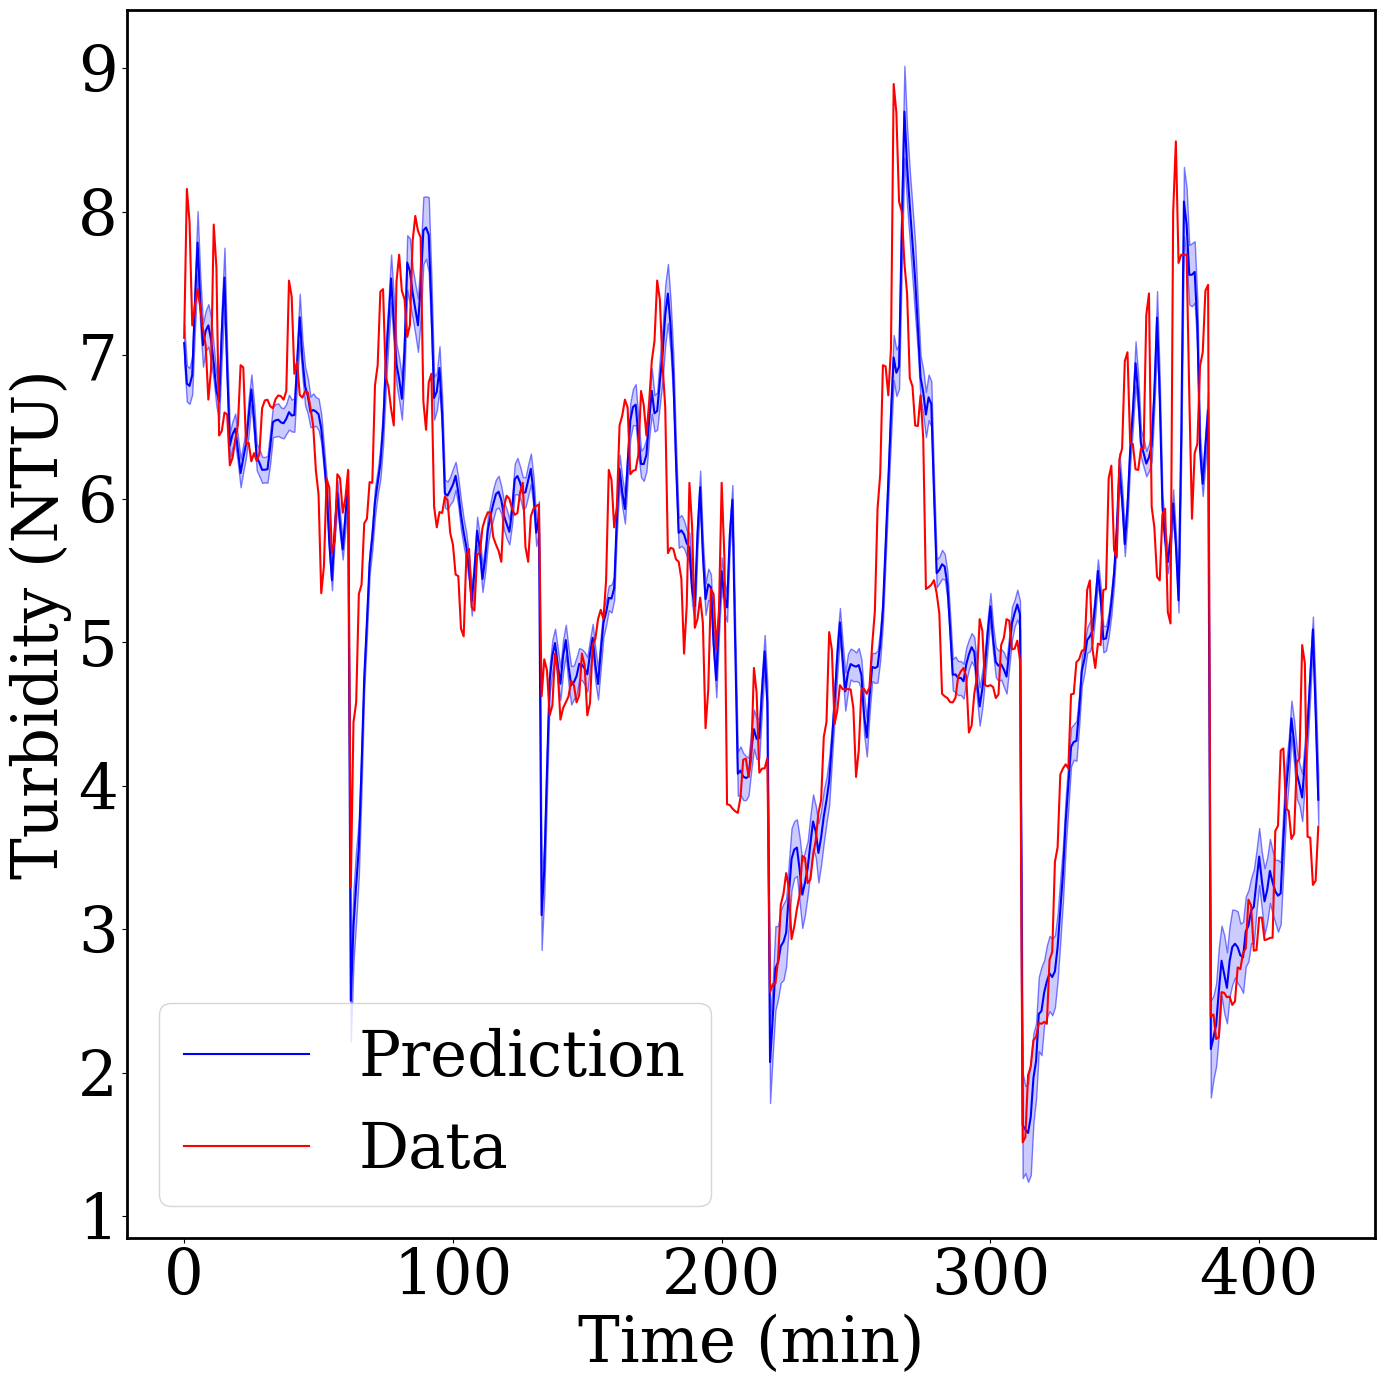

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-51-afca95c733ff>", line 19, in <cell line: 5>
    plt.savefig(path_save + '/test.png', dpi = 600)
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py", line 1023, in savefig
    res = fig.savefig(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/figure.py", line 3343, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/backend_bases.py", line 2366, in print_figure
    result = print_method(
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/backend_bases.py", line 2232, in <lambda>
    print_method = functools.wraps(meth)(lambda *args, **kwargs: meth(
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/backends/backend_agg.py", line 509, in print_png
 

<Figure size 640x480 with 0 Axes>

In [ ]:
x = np.linspace(0, len(prediction_test)-1, len(prediction_test))
# test, axs = plt.subplots(math.ceil(no/2), 2, figsize=(15, 15))
line = 0
column = 0
for i in range(no):
  if no == 1:
    x = np.linspace(0, (len(prediction_test)-1)*filter_size/60, len(prediction_test))
    plt.figure(figsize=(15, 15))
    plt.plot(x, prediction_test, color='#0000ff', label = "Prediction")
    a = (te_lower).astype('float32').reshape(len(prediction_test))
    b = (te_upper).astype('float32').reshape(len(prediction_test))
    plt.fill_between(x, a, b, alpha=0.5, edgecolor='#0000ff', facecolor='#9999ff')
    plt.plot(x, y_test_d, color='#ff0000', label = "Data")
    plt.legend(loc='lower left')
    plt.ylabel('Turbidity (NTU)')
    plt.xlabel('Time (min)')
    plt.tight_layout()
    plt.show()
    plt.savefig(path_save + '/test.png', dpi = 600)
  else:
    if column == 0:
      axs[line, 0].plot(x, prediction_test[:, i], color='#0000ff', label = "Prediction")
      a = (te_lower[:, i]).astype('float32').reshape(len(prediction_test))
      b = (te_upper[:, i]).astype('float32').reshape(len(prediction_test))
      axs[line, 0].fill_between(x, a, b, alpha=0.5, edgecolor='#0000ff', facecolor='#9999ff')
      axs[line, 0].plot(x, y_test_d, color='#ff0000', label = "Data")
      # plt.legend(loc='lower right')
      plt.ylabel('Turbidity (NTU)')
      plt.xlabel('Time (min)')
      plt.xlim([0, len(x)-1])
      plt.tight_layout()
      column = 1
    else:
      axs[line, 1].plot(x, prediction_test[:, i], color='#0000ff', label = "Prediction")
      a = (te_lower[:, i]).astype('float32').reshape(len(prediction_test))
      b = (te_upper[:, i]).astype('float32').reshape(len(prediction_test))
      axs[line, 1].fill_between(x, a, b, alpha=0.5, edgecolor='#0000ff', facecolor='#9999ff')
      axs[line, 1].plot(x, y_test_d, color='#ff0000', label = "Data")
      # plt.legend(loc='lower right')
      plt.ylabel('Turbidity (NTU)')
      plt.xlabel('Time (min)')
      plt.xlim([0, len(x)-1])
      plt.tight_layout()
      column = 0
      line += 1
  # plt.figure(figsize=(15, 15))
  # test.show()
  # test.savefig(path_save + '/test.png', dpi = 600)
# !cp test path_save

# files.download('/content/drive/MyDrive/Doutorado/Códigos/Bayesian/uncertainty_sem.png')

ValueError: ignored

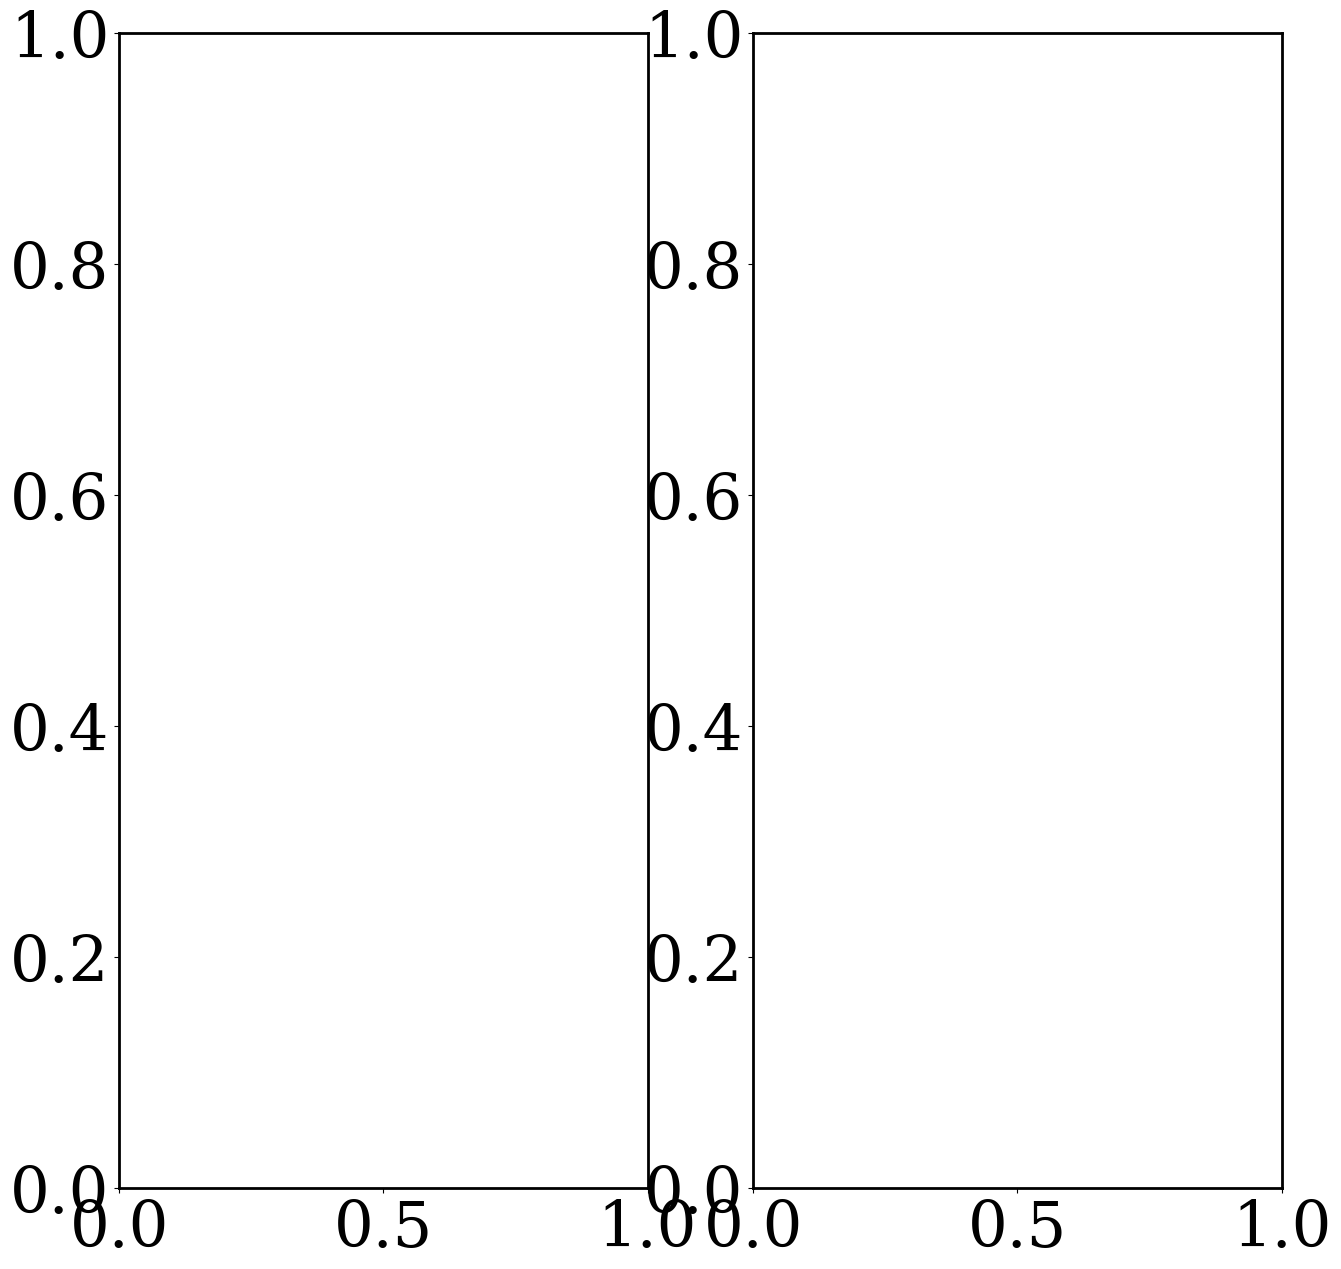

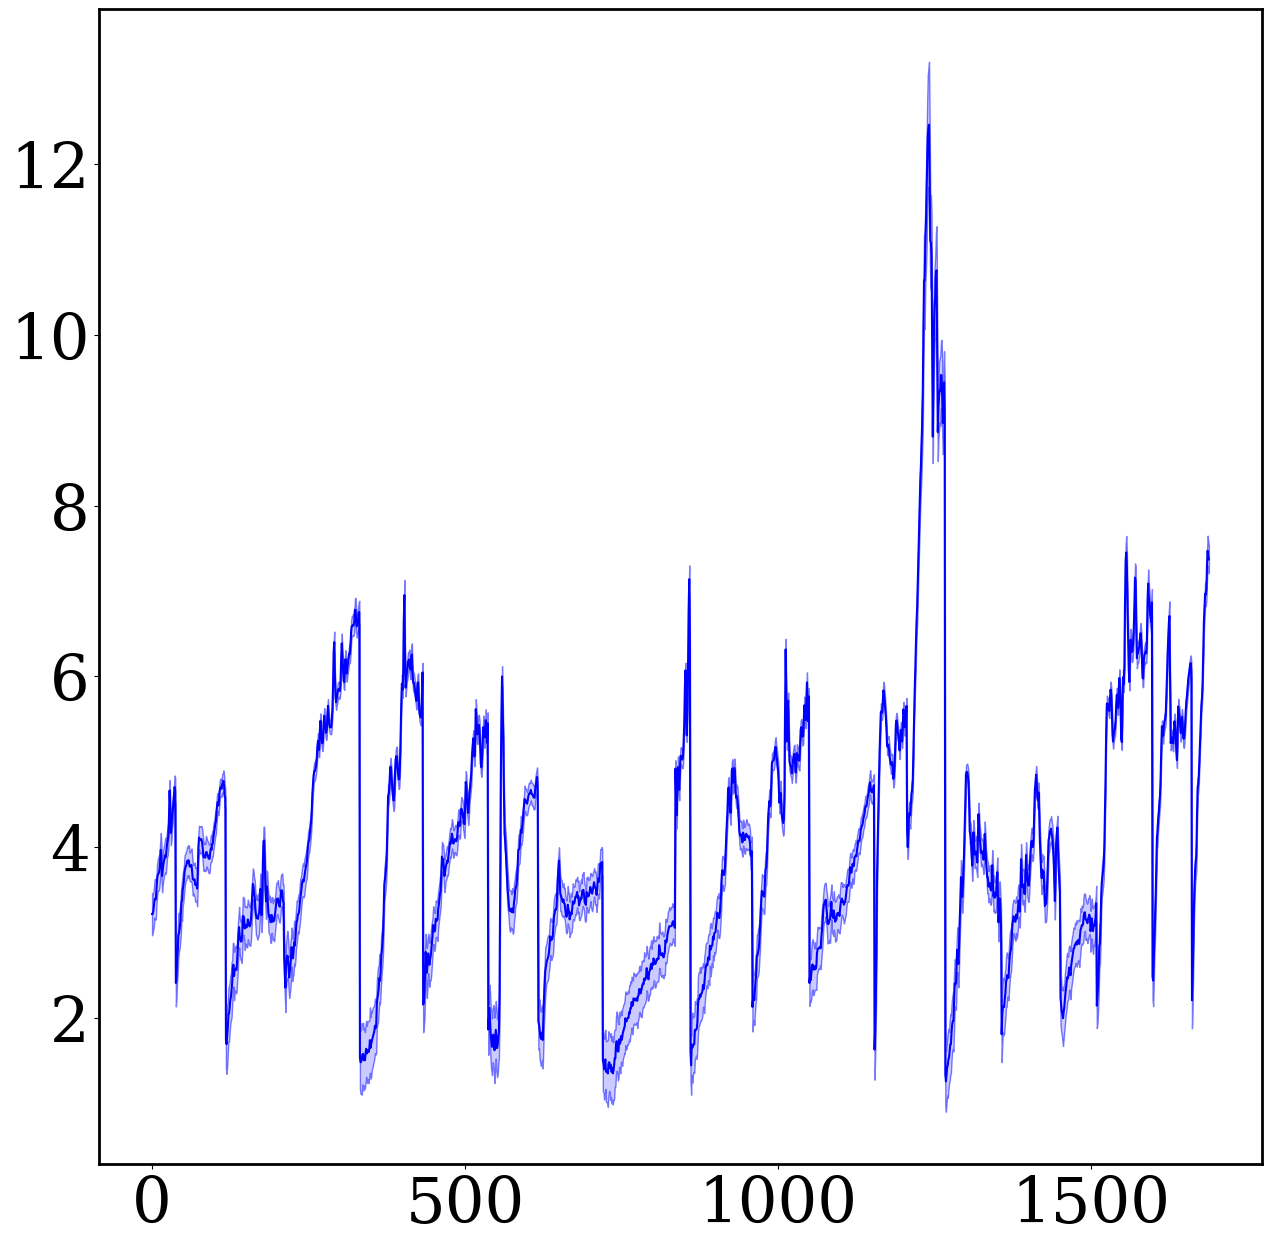

In [ ]:
x = np.linspace(0, len(prediction_train)-1, len(prediction_train))
test, axs = plt.subplots(math.ceil(no/2), 2, figsize=(15, 15))
line = 0
column = 0
for i in range(no):
  if no == 1:
    x = np.linspace(0, (len(prediction_train)-1)*filter_size/60, len(prediction_train))
    test, axs = plt.subplots(1, 1, figsize=(15, 15))
    axs.plot(x, prediction_train, color='#0000ff', label = "Prediction")
    a = (tr_lower).astype('float32').reshape(len(prediction_train))
    b = (tr_upper).astype('float32').reshape(len(prediction_train))
    axs.fill_between(x, a, b, alpha=0.5, edgecolor='#0000ff', facecolor='#9999ff')
    axs.plot(x, y_test_d, color='#ff0000', label = "Data")
    plt.legend(loc='lower right')
    plt.ylabel('Turbidity (NTU)')
    plt.xlabel('Time (min)')
    # plt.xlim([0, len(x)-1])
    # plt.ylim([min(prediction_train)-.1, max(prediction_train)+.1])
    # axs.set_facecolor('white')
    plt.tight_layout()
    # plt.figure(figsize=(15, 15))

  else:
    if column == 0:
      axs[line, 0].plot(x, prediction_train[:, i], color='#0000ff', label = "Prediction")
      a = (tr_lower[:, i]).astype('float32').reshape(len(prediction_train))
      b = (tr_upper[:, i]).astype('float32').reshape(len(prediction_train))
      axs[line, 0].fill_between(x, a, b, alpha=0.5, edgecolor='#0000ff', facecolor='#9999ff')
      axs[line, 0].plot(x, y_train_d, color='#ff0000', label = "Data")
      # plt.legend(loc='lower right')
      plt.ylabel('Turbidity (NTU)')
      plt.xlabel('Time (min)')
      plt.xlim([0, len(x)-1])
      plt.tight_layout()
      column = 1
    else:
      axs[line, 1].plot(x, prediction_train[:, i], color='#0000ff', label = "Prediction")
      a = (tr_lower[:, i]).astype('float32').reshape(len(prediction_train))
      b = (tr_upper[:, i]).astype('float32').reshape(len(prediction_train))
      axs[line, 1].fill_between(x, a, b, alpha=0.5, edgecolor='#0000ff', facecolor='#9999ff')
      axs[line, 1].plot(x, y_train_d, color='#ff0000', label = "Data")
      # plt.legend(loc='lower right')
      plt.ylabel('Turbidity (NTU)')
      plt.xlabel('Time (min)')
      plt.xlim([0, len(x)-1])
      plt.tight_layout()
      column = 0
      line += 1
plt.figure(figsize=(15, 15))
test.show()
test.savefig(path_save + '/train.png', dpi = 600)

In [ ]:
train_R = plt.figure(figsize=(15, 15))

train_R, axs = plt.subplots(math.ceil(no/2), 2, sharex=True, sharey=True, figsize=(15, 15))
line = 0
column = 0
for i in range(no):
  if no == 1:
    plt.plot(prediction_train, y_train_d, 'rx')
    plt.plot([min(y_train_d), max(y_train_d)], [min(y_train_d), max(y_train_d)], 'b')
    plt.ylabel('Data (NTU)')
    plt.xlabel('Predicted (NTU)')
    slope, intercept, r_value, p_value, std_err = linregress(prediction_train[:,0], y_train_d[:,0])
    # plt.annotate("r-squared = {:.3f}".format(r2_score(y_test, y_predicted)), (0, 1))
    plt.annotate('$R^2$= ' + str("{:.2f}".format(r_value)))
    plt.annotate('$m$ = ' + str("{:.2f}".format(slope)))
    train_R.savefig(path_save + '/train_R.png', dpi = 600)

  else:
    if column == 0:
      axs[line, 0].plot(prediction_train[:, i], y_train_d[:, i], 'rx')
      axs[line, 0].plot([min(y_train_d[:,i]), max(y_train_d[:,i])], [min(y_train_d[:,i]), max(y_train_d[:,i])], 'b')
      slope, intercept, r_value, p_value, std_err = linregress(prediction_train[:,i], y_train_d[:,i])
      axs[line, 0].annotate('$R^2$= ' + str("{:.2f}".format(r_value)), xy=(0.05, 0.89), xycoords='axes fraction')
      axs[line, 0].annotate('$m$ = ' + str("{:.2f}".format(slope)), xy=(0.05, 0.8), xycoords='axes fraction')
      plt.tight_layout()
      column = 1
    else:
      axs[line, 1].plot(prediction_train[:, i], y_train_d[:, i], 'rx')
      axs[line, 1].plot([min(y_train_d[:,i]), max(y_train_d[:,i])], [min(y_train_d[:,i]), max(y_train_d[:,i])], 'b')
      slope, intercept, r_value, p_value, std_err = linregress(prediction_train[:,i], y_train_d[:,i])
      axs[line, 1].annotate('$R^2$= ' + str("{:.2f}".format(r_value)), xy=(0.05, 0.89), xycoords='axes fraction')
      axs[line, 1].annotate('$m$ = ' + str("{:.2f}".format(slope)), xy=(0.05, 0.8), xycoords='axes fraction')
      plt.tight_layout()
      column = 0
      line += 1
plt.ylabel('Data (NTU)')
plt.xlabel('Predicted (NTU)')
plt.figure(figsize=(15, 15))
train_R.show()
train_R.savefig(path_save + '/train_R.png', dpi = 600)

In [ ]:
test_R = plt.figure(figsize=(15, 15))

test, axs = plt.subplots(math.ceil(no/2), 2, sharex=True, sharey=True, figsize=(15, 15))
line = 0
column = 0
for i in range(no):
  if no == 1:
    plt.plot(prediction_test, y_test_d, 'rx')
    plt.plot([min(y_test_d), max(y_test_d)], [min(y_test_d), max(y_test_d)], 'b')
    plt.ylabel('Data (NTU)')
    plt.xlabel('Predicted (NTU)')
    slope, intercept, r_value, p_value, std_err = linregress(prediction_test[:,0], y_test_d[:,0])
    # plt.annotate("r-squared = {:.3f}".format(r2_score(y_test, y_predicted)), (0, 1))
    plt.annotate('$R^2$= ' + str("{:.2f}".format(r_value)))
    plt.annotate('$m$ = ' + str("{:.2f}".format(slope)))
    train_R.savefig(path_save + '/train_R.png', dpi = 600)

  else:
    if column == 0:
      axs[line, 0].plot(prediction_test[:, i], y_test_d[:, i], 'rx')
      axs[line, 0].plot([min(y_test_d[:,i]), max(y_test_d[:,i])], [min(y_test_d[:,i]), max(y_test_d[:,i])], 'b')
      slope, intercept, r_value, p_value, std_err = linregress(prediction_test[:,i], y_test_d[:,i])
      axs[line, 0].annotate('$R^2$= ' + str("{:.2f}".format(r_value)), xy=(0.05, 0.89), xycoords='axes fraction')
      axs[line, 0].annotate('$m$ = ' + str("{:.2f}".format(slope)), xy=(0.05, 0.8), xycoords='axes fraction')
      plt.tight_layout()
      column = 1
    else:
      axs[line, 1].plot(prediction_test[:, i], y_test_d[:, i], 'rx')
      axs[line, 1].plot([min(y_test_d[:,i]), max(y_test_d[:,i])], [min(y_test_d[:,i]), max(y_test_d[:,i])], 'b')
      slope, intercept, r_value, p_value, std_err = linregress(prediction_test[:,i], y_test_d[:,i])
      axs[line, 1].annotate('$R^2$= ' + str("{:.2f}".format(r_value)), xy=(0.05, 0.89), xycoords='axes fraction')
      axs[line, 1].annotate('$m$ = ' + str("{:.2f}".format(slope)), xy=(0.05, 0.8), xycoords='axes fraction')
      plt.tight_layout()
      column = 0
      line += 1
plt.ylabel('Data (NTU)')
plt.xlabel('Predicted (NTU)')
plt.figure(figsize=(15, 15))
test_R.show()
train_R.savefig(path_save + '/test_R.png', dpi = 600)

In [ ]:
model = load_LSTM_model()

Loaded model from disk


In [ ]:
erro_train = y_train_d-prediction_train
print(max(erro_train))
print(min(erro_train))
erro_test = y_test_d-prediction_test
print(max(erro_test))
print(min(erro_test))

[3.71093768]
[-2.34216364]
[2.80720381]
[-2.12949996]


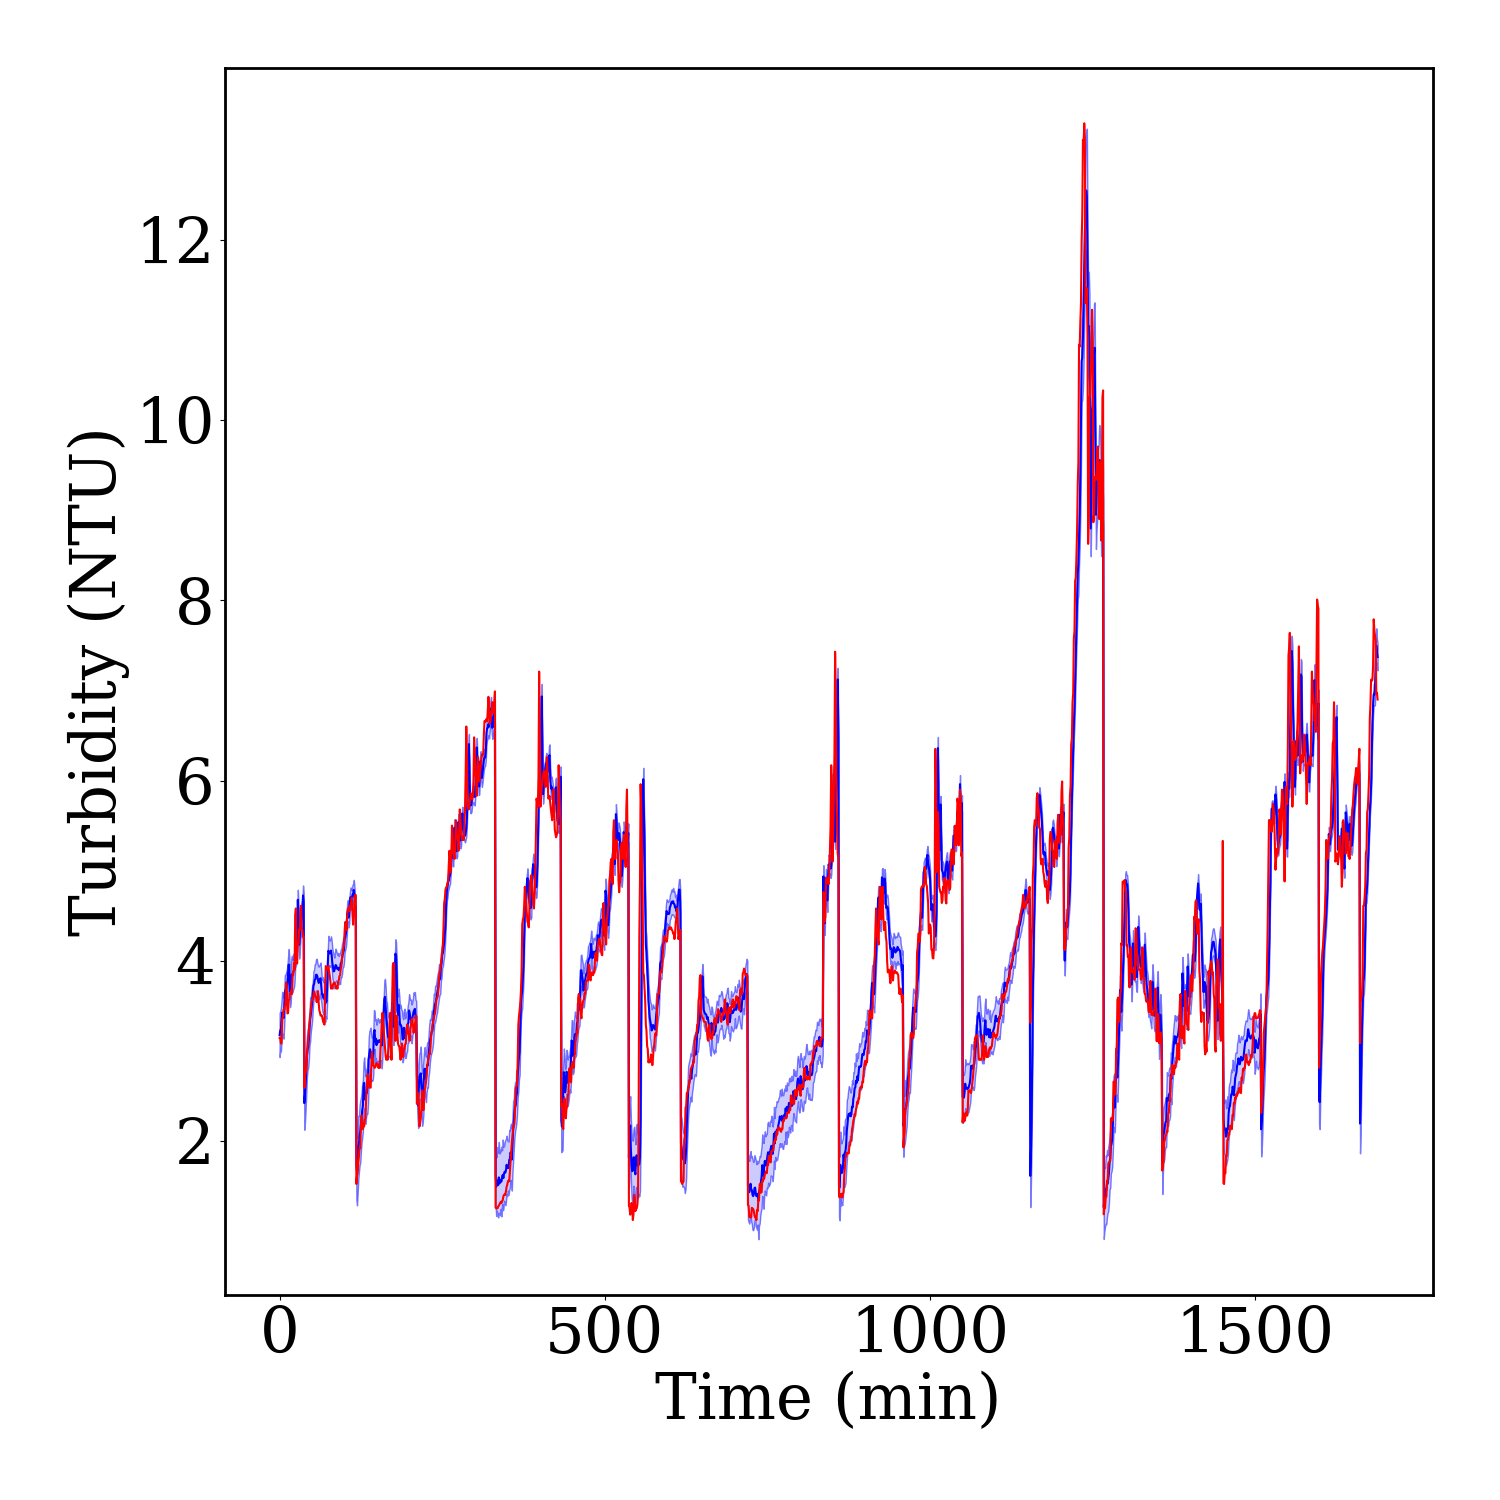

In [ ]:
%matplotlib ipympl
# fig, axs = plt.subplots()
# ax.plot(erro_train)

x = np.linspace(0, (len(prediction_train)-1)*filter_size/60, len(prediction_train))
test_zoom, axs = plt.subplots(1, 1, figsize=(15, 15))
axs.plot(x, prediction_train, color='#0000ff', label = "Prediction")
a = (tr_lower).astype('float32').reshape(len(prediction_train))
b = (tr_upper).astype('float32').reshape(len(prediction_train))
axs.fill_between(x, a, b, alpha=0.5, edgecolor='#0000ff', facecolor='#9999ff')
axs.plot(x, y_train_d, color='#ff0000', label = "Data")
# plt.legend(loc='lower right')
plt.ylabel('Turbidity (NTU)')
plt.xlabel('Time (min)')
# plt.xlim([0, len(x)-1])
# plt.ylim([min(prediction_train)-.1, max(prediction_train)+.1])
plt.tight_layout()


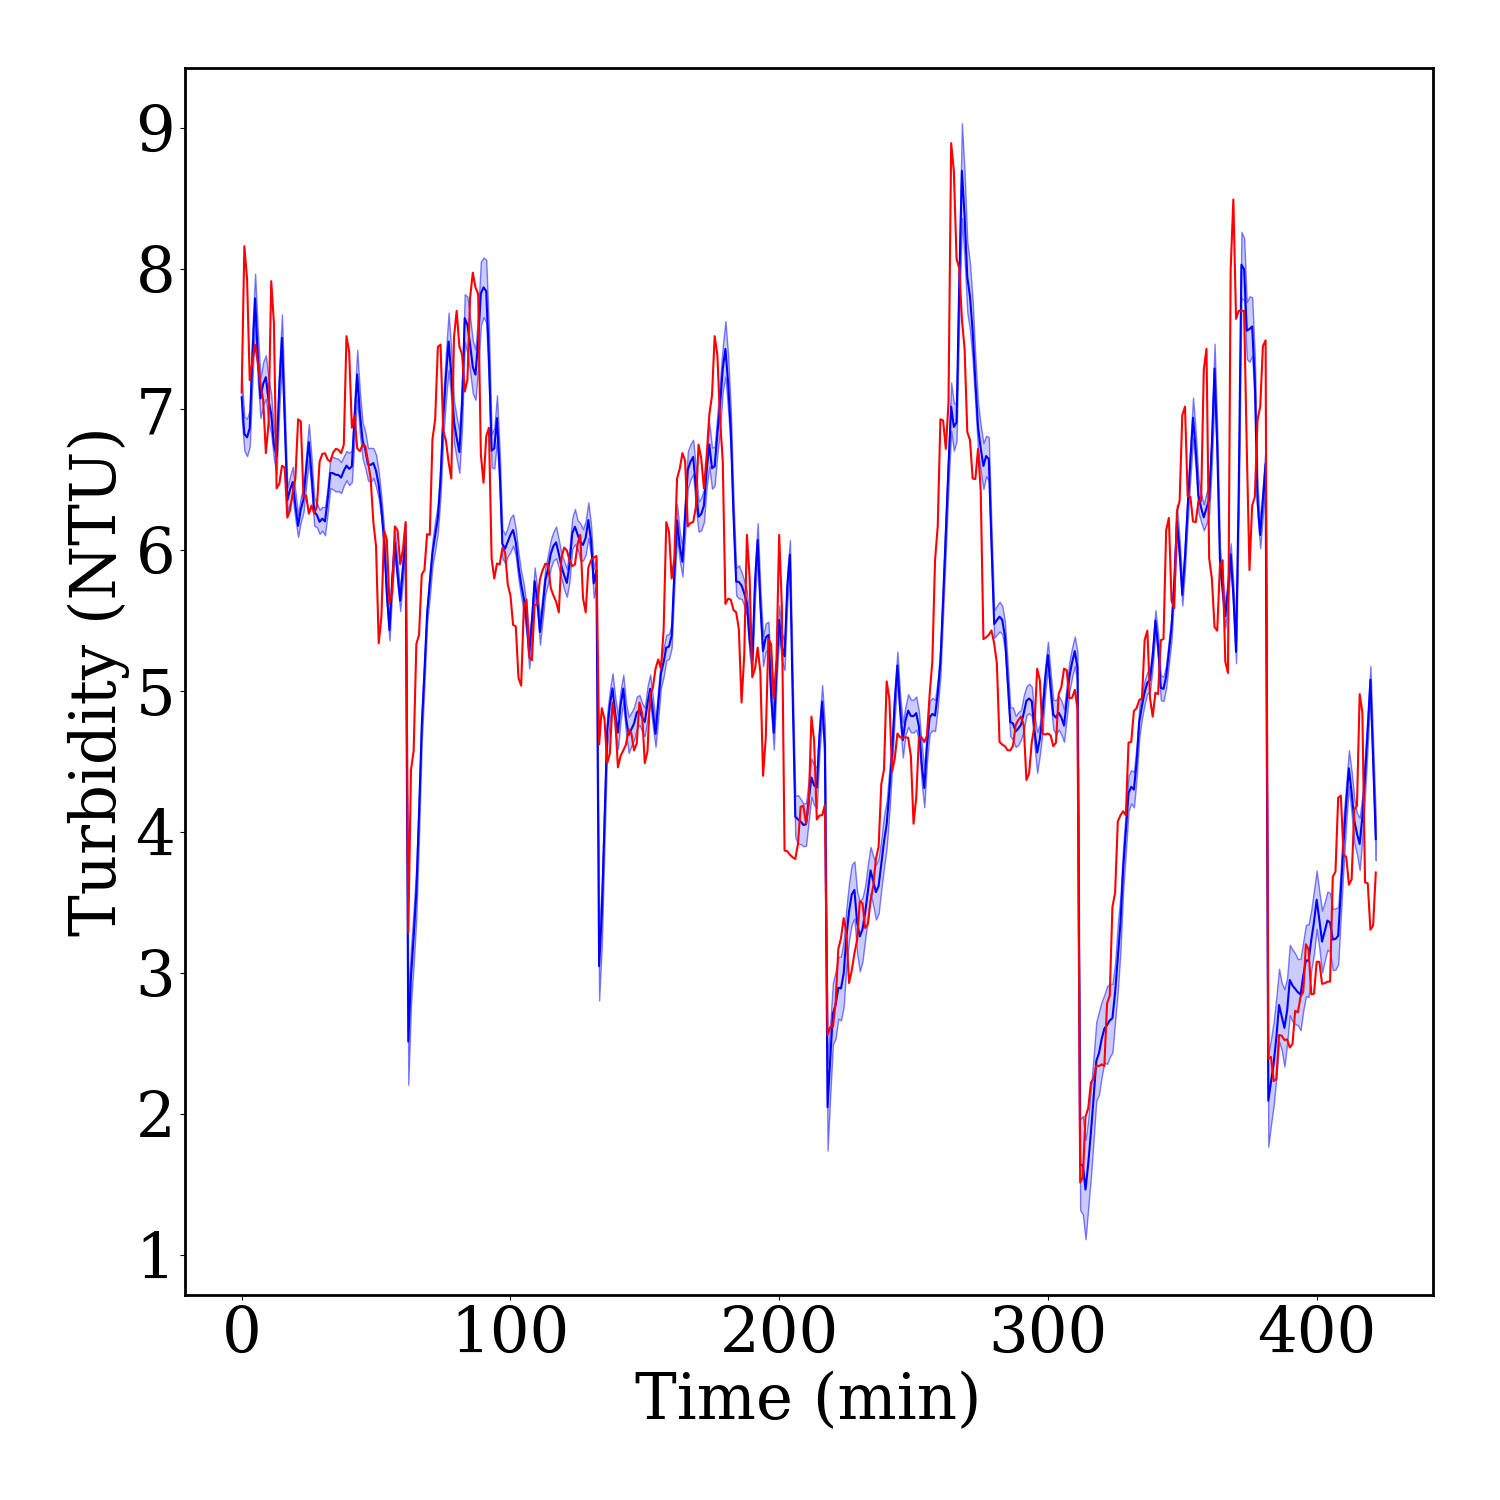

In [ ]:
%matplotlib ipympl

x = np.linspace(0, (len(prediction_test)-1)*filter_size/60, len(prediction_test))
test_zoom, axs = plt.subplots(1, 1, figsize=(15, 15))
axs.plot(x, prediction_test, color='#0000ff', label = "Prediction")
a = (te_lower).astype('float32').reshape(len(prediction_test))
b = (te_upper).astype('float32').reshape(len(prediction_test))
axs.fill_between(x, a, b, alpha=0.5, edgecolor='#0000ff', facecolor='#9999ff')
axs.plot(x, y_test_d, color='#ff0000', label = "Data")
# plt.legend(loc='lower right')
plt.ylabel('Turbidity (NTU)')
plt.xlabel('Time (min)')
# plt.xlim([0, len(x)-1])
# plt.ylim([min(prediction_train)-.1, max(prediction_train)+.1])
plt.tight_layout()
plt.show()

In [ ]:
test_zoom.savefig(path_save + '/zoom_teste.png', dpi = 600)

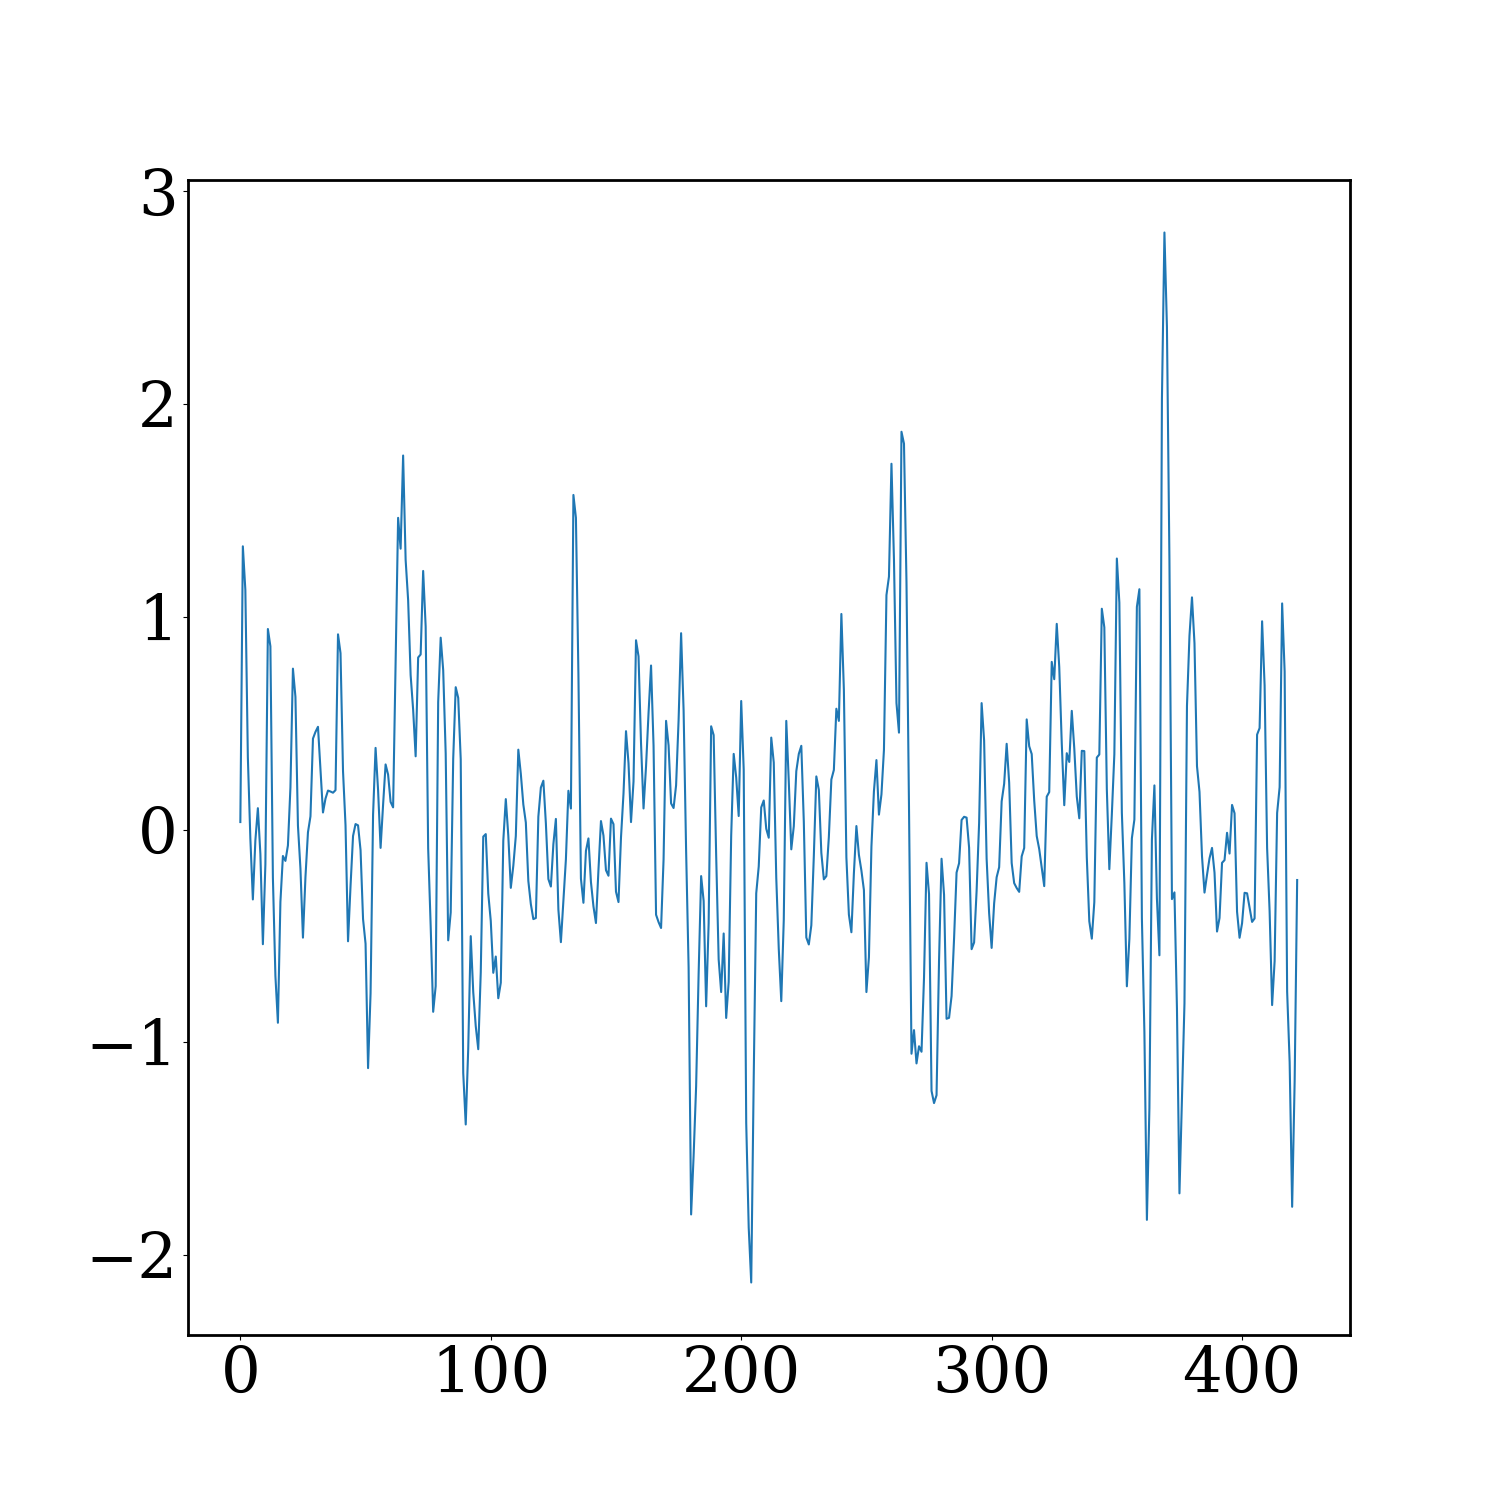

In [ ]:
%matplotlib ipympl
fig, ax = plt.subplots(figsize=(15, 15))
ax.plot(erro_test)